In [1]:
import numpy as np
from scipy.sparse import rand as sprand
import torch
import matplotlib.pyplot as plt


# Make up some random explicit feedback ratings
# and convert to a numpy array
n_users = 1_00
n_items = 1_00
ratings = sprand(n_users, n_items, density=1, format="csr")
ratings.data = np.random.randint(0, 6, size=ratings.nnz).astype(np.float64)
ratings = ratings.toarray()

In [2]:
ratings.shape

(100, 100)

In [3]:
split_size = 0.8
batch_size = 1024


In [4]:
import pandas as pd

ratings_df = pd.read_csv("ml-1m/ratings.dat",delimiter='::',header=None,names=['userId','movieId','rating','timestamp'])
ratings_df = ratings_df.drop(columns=['timestamp'])

ratings_df
ratings = ratings_df.to_numpy()


C:\Users\Poseidon\AppData\Local\Temp\ipykernel_3640\1224416200.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv("ml-1m/ratings.dat",delimiter='::',header=None,names=['userId','movieId','rating','timestamp'])


In [5]:
ratings_df

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [6]:
# store the ratings in a matrix with ids as indices
n_users = ratings_df.userId.max()
n_items = ratings_df.movieId.max()

ratings = np.zeros((n_users, n_items))

for row in ratings_df.itertuples():
    ratings[row.userId-1, row.movieId-1] = row.rating
    


In [7]:
ratings


array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [8]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors )
        self.item_factors = torch.nn.Embedding(n_items, n_factors)

        self.user_factors.weight.data.uniform_(-3,3)
        self.item_factors.weight.data.uniform_(-3,3)

    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)

In [9]:
class CosineMatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors )
        self.item_factors = torch.nn.Embedding(n_items, n_factors)

        

        self.user_factors.weight.data.uniform_(-3,3)
        self.item_factors.weight.data.uniform_(-3,3)




    def forward(self, user, item):
        # normalize the embeddings
        self.user_factors.weight.data = torch.nn.functional.normalize(self.user_factors.weight.data, p=2, dim=1)
        self.item_factors.weight.data = torch.nn.functional.normalize(self.item_factors.weight.data, p=2, dim=1)
        
        return torch.nn.functional.cosine_similarity(self.user_factors(user), self.item_factors(item), dim=1)*2.5+2.5
    

In [10]:
model = CosineMatrixFactorization(n_users, n_items, n_factors=30)


In [11]:
#RMSE LOSS class
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


In [12]:
loss_func =RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)  # learning rate




In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        self.ratings = ratings
        self.users, self.items = ratings.nonzero()
        # convert to tensor
        self.users = torch.LongTensor(self.users)
        self.items = torch.LongTensor(self.items)
        self.ratings = torch.FloatTensor(self.ratings[self.users, self.items])
       

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            self.users[idx],
            self.items[idx],
            self.ratings[idx],
            
        )


In [15]:
# Create the dataset and dataloader
dataset = Dataset(ratings)
# split into train and test
train_size = int(split_size * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50000, shuffle=True)



In [16]:
len(dataset.ratings)

1000209

In [17]:
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
# train the model
epochs = 40
train_losses = []
test_losses = []
for epoch in range(epochs):
    model.train()
    for user, item, rating in train_dataloader:
        prediction = model(user, item)
        loss = loss_func(prediction, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for user, item, rating in test_dataloader:
            prediction = model(user, item)
            loss = loss_func(prediction, rating)
        test_losses.append(loss.item())
    print(f"Epoch {epoch}, Train Loss {np.mean(train_losses)}, Test Loss {np.mean(test_losses)}")

Epoch 0, Train Loss 0.8086116909980774, Test Loss 0.92374187707901
Epoch 1, Train Loss 0.797596275806427, Test Loss 0.9871201813220978
Epoch 2, Train Loss 0.8271990219751993, Test Loss 0.9031800826390585
Epoch 3, Train Loss 0.8305206447839737, Test Loss 0.8986663818359375


KeyboardInterrupt: 

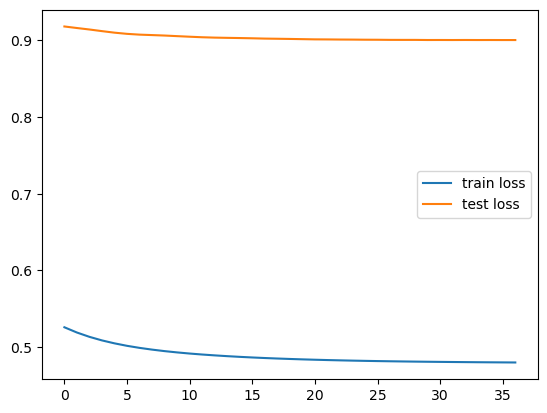

In [ ]:
#plot the loss
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

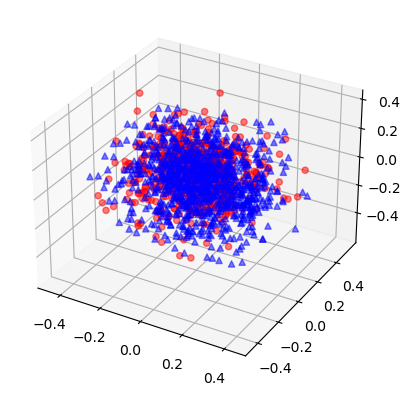

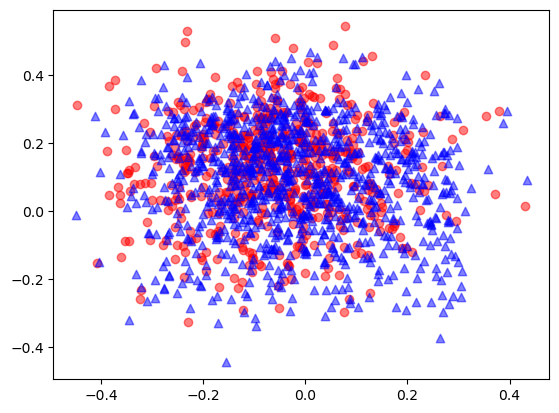

In [ ]:
# get the embeddings
user_factors = model.user_factors.weight.data.cpu().numpy()
item_factors = model.item_factors.weight.data.cpu().numpy()[:1000]

# plot the embedddings in 3d 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_factors[:,0], user_factors[:,1], user_factors[:,2], c='r', marker='o',alpha=0.5)
ax.scatter(item_factors[:,0], item_factors[:,1], item_factors[:,2], c='b', marker='^',alpha=0.5)
plt.show()

# plot the embedddings in 2d
plt.scatter(user_factors[:,0], user_factors[:,1], c='r', marker='o',alpha=0.5)
plt.scatter(item_factors[:,0], item_factors[:,1], c='b', marker='^',alpha=0.5)
plt.show()




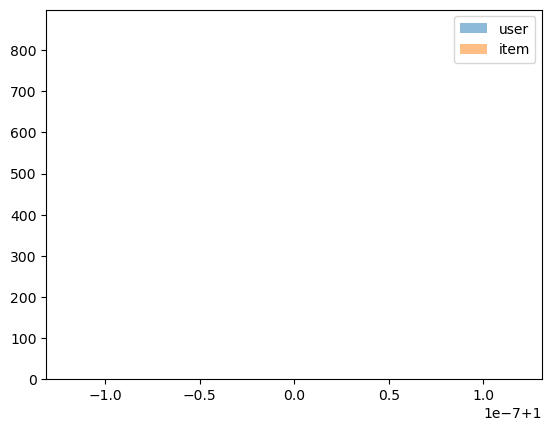

In [ ]:
# distribution of the norm of the embeddings
plt.hist(np.linalg.norm(user_factors, axis=1), bins=20, alpha=0.5, label="user")
plt.hist(np.linalg.norm(item_factors, axis=1), bins=20, alpha=0.5, label="item")
plt.legend()
plt.show()

In [ ]:
ratings_df[ratings_df['movieId'] == 163981]

,userId,movieId,rating
100828,610,163981,3.5


In [ ]:
# predict rating of user 610 for movie 163981
user = torch.LongTensor([609])
item = torch.LongTensor([163980])
prediction = model(user, item)
print(prediction)

tensor([3.5045], grad_fn=<AddBackward0>)
